In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)
# Grafika
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

# modelowanie
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
from sklearn.preprocessing import RobustScaler, StandardScaler

In [3]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [4]:
# Zbiór MNIST 70000 rysunków cyfr
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',cache=True)

In [5]:
X = mnist.data.values
y = mnist.target

In [6]:
X # 70000 obrazków i każdy ma 784 (28 x 28) cechy 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [8]:
y = y.astype(int)

In [9]:
X.shape

(70000, 784)

In [10]:
y.shape

(70000,)

In [11]:
some_number = X[69998]

In [12]:
some_number

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [13]:
some_number_image = some_number.reshape(28,28)

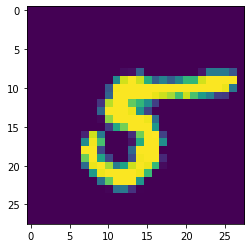

In [14]:
plt.imshow(some_number_image)

In [15]:
y[69998]

5

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

In [17]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [18]:
# tasowanie danych - 
shuffle_index = np.random.permutation(60000)

In [19]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [20]:
# identyfikowanie binarne np 5 ! dwie klasy: jest 5 nie - to nie jest 5 
y_train_5 = np.where(y_train==5,1,0)
y_test_5 = np.where(y_test==5,1,0)

In [21]:
# wybierzmy jakiś prosty klasyfikator 
from sklearn.linear_model import SGDClassifier

In [22]:
sgd = SGDClassifier(random_state=43)
sgd.fit(X_train,y_train_5)

SGDClassifier(random_state=43)

In [23]:
sgd.predict([some_number])

array([1])

In [24]:
# ocenimy wydajność - ile % dobrze określił model 

from sklearn.model_selection import cross_val_score

cross_val_score(sgd, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.92485, 0.9623 , 0.95815])

### Dokładność powyżej 95% !!! 

Ale czy to dobrze ? 

Bądźmy jak na Titanicu - określmy, że wszyscy umarli ! tzn. napiszmy klasyfikator, który zawsze zwróci nie_5

In [25]:
from sklearn.base import BaseEstimator

In [26]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1))

### Jak myślisz jaka będzie dokładność takiego modelu ? 

In [27]:
never_5 = Never5Classifier()
cross_val_score(never_5, X_train,y_train_5, cv=3, scoring='accuracy')

array([0.91095, 0.9106 , 0.9074 ])

### Macierz pomyłek 

Znacznie lepszym sposobem oceny jakości klasyfikatora jest macierz pomyłek (confusion matrix)

W celu obliczenia macierzy wpierw trzeba otrzymać prognozy

Rząd reprezentuje rzeczywistą klasę, kolumna przewidywaną klasę. 

In [28]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd, X_train,y_train_5, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52583,  1996],
       [ 1098,  4323]])

Prawidłowo sklasyfikowane = 53110 (niebędące piątką Prawdziwe Negatywne)

1469 = Fałszywie Pozytywne, 

877 = Fałszywie Negatywne, oraz 

4544= Prawdziwie Pozytywne (będące piątkami)   

(Wyniki mogą być różne ze względu na funkcję zmieniającą indeksy)

$$Precyzja = \frac{PP}{PP+FP}$$ używana wraz z pełnością
$$Pełność= \frac{PP}{PP+FN}$$

, czułością lub odsetkiem pozytywnych

In [30]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.6841272353220447

In [31]:
4544/(4544+1469) # nie myli się w 75% 

0.7556959920172959

In [32]:
recall_score(y_train_5,y_train_pred) 

0.7974543442169342

In [33]:
4544/(4544+877) # rozpoznaje 83%

0.8382217303080612

In [34]:
DATA_DIR = 'dane'
DATA_NAME = 'creditcard.csv'

In [35]:
def load_csv_data():
    csv_path = os.path.join(DATA_DIR,DATA_NAME)
    return pd.read_csv(csv_path)

In [36]:
df = load_csv_data()

In [37]:
df['Class'].value_counts()

0    99778
1      223
Name: Class, dtype: int64

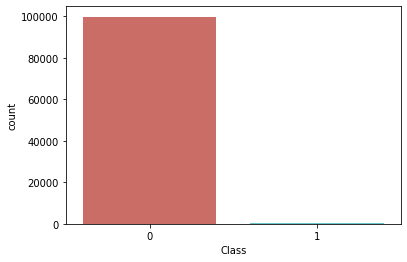

In [38]:
sns.countplot(x='Class',data=df, palette='hls')
plt.show()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  100001 non-null  int64  
 1   Time        100001 non-null  float64
 2   V1          100001 non-null  float64
 3   V2          100001 non-null  float64
 4   V3          100001 non-null  float64
 5   V4          100001 non-null  float64
 6   V5          100001 non-null  float64
 7   V6          100001 non-null  float64
 8   V7          100001 non-null  float64
 9   V8          100001 non-null  float64
 10  V9          100001 non-null  float64
 11  V10         100001 non-null  float64
 12  V11         100001 non-null  float64
 13  V12         100001 non-null  float64
 14  V13         100001 non-null  float64
 15  V14         100001 non-null  float64
 16  V15         100001 non-null  float64
 17  V16         100001 non-null  float64
 18  V17         100001 non-null  float64
 19  V1

In [40]:
df.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [41]:
df.sample(5)

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
66063,66063,51864.0,-0.607437,1.079169,0.601784,-0.451120,0.860896,0.541607,0.476645,0.320225,-0.327456,-0.068240,0.487771,0.105386,-0.048415,-0.295085,0.595956,0.673676,-0.442282,0.364410,0.316339,0.241227,-0.308446,-0.757426,-0.146081,-1.378292,-0.042997,0.173172,0.369695,0.129796,13.99,0
11889,11889,20467.0,-0.974395,0.425079,2.339517,-0.531438,1.051416,2.015580,0.078785,0.492245,2.087510,-1.375991,0.246330,-2.496814,0.820541,0.841865,-0.589497,-0.579014,0.771575,-1.538501,-3.310400,-0.464490,-0.081201,0.362281,-0.151474,-1.603282,-0.350542,-0.671423,-0.110405,-0.119405,9.99,0
44319,44319,41891.0,1.208487,-0.661466,-0.355504,-1.550452,-0.611347,-1.086109,0.184491,-0.369215,-0.408208,-0.242110,0.106109,1.007866,1.204786,0.323816,1.368470,-2.629605,0.406567,0.253842,-0.351270,-0.305709,-0.578519,-1.255594,0.056953,0.044442,0.436264,-0.918448,0.053379,0.038513,101.40,0
77372,77372,57019.0,1.170775,0.258305,0.238183,1.026308,-0.069653,-0.564826,0.257246,-0.245978,-0.119119,-0.065198,-0.583151,0.771853,1.473746,0.046518,0.916842,0.262299,-0.731186,-0.158347,-0.210249,0.065311,-0.040510,-0.136166,-0.142307,-0.094233,0.634927,-0.417378,0.020994,0.032220,54.99,0
47205,47205,43132.0,1.264926,-0.804998,0.415954,-0.392719,-1.225063,-0.808719,-0.504353,-0.151034,-0.359487,0.477927,-0.694957,-0.652783,-0.550926,-0.331845,-0.414275,0.613535,0.716629,-1.681588,0.921966,0.142130,0.011811,-0.053353,-0.083775,0.411988,0.512739,-0.249772,-0.002644,0.023585,76.23,0


In [42]:
target = df['Class']

df2 = df.copy()
df2 = df2.drop(columns=['Time'])
df3 = df2.drop(columns=['Class','Unnamed: 0'])

In [43]:
df3.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000
mean,-0.262182,-0.032294,0.676205,0.162566,-0.278488,0.094099,-0.108711,0.056020,-0.046474,-0.023088,0.250237,-0.066028,0.007593,0.059912,0.192995,-0.007712,0.058048,-0.092294,-0.021986,0.044609,-0.030861,-0.109102,-0.037023,0.008978,0.132205,0.026659,0.000628,0.001738,97.960297
std,1.859217,1.656978,1.322925,1.349263,1.356392,1.301385,1.210913,1.207520,1.121390,1.070855,1.067023,1.112746,1.037955,0.965546,0.929697,0.898753,0.942828,0.846054,0.817317,0.759536,0.718888,0.634314,0.632905,0.595271,0.441078,0.494537,0.393742,0.325161,264.621869
min,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,-18.271168,-4.049895,-17.769143,-5.791881,-19.214325,-4.152532,-13.563273,-25.162799,-9.498746,-7.213527,-21.024817,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000
25%,-1.028110,-0.598683,0.176739,-0.711504,-0.898663,-0.647789,-0.600200,-0.137454,-0.698812,-0.496338,-0.524066,-0.482951,-0.678242,-0.332673,-0.358108,-0.481345,-0.401051,-0.561829,-0.516034,-0.169245,-0.224510,-0.531336,-0.176415,-0.323713,-0.131782,-0.325102,-0.062533,-0.005355,7.570000
50%,-0.260559,0.078317,0.753962,0.192532,-0.314370,-0.157006,-0.069107,0.074142,-0.119105,-0.094912,0.180619,0.113271,-0.007854,0.077858,0.299874,0.066700,-0.001101,-0.086530,-0.026019,-0.024568,-0.057669,-0.083875,-0.049237,0.064999,0.170104,-0.070320,0.009834,0.023318,26.310000
75%,1.153321,0.735885,1.376306,1.032416,0.249744,0.486361,0.414657,0.360521,0.558309,0.439030,1.065090,0.623731,0.684385,0.491215,0.864868,0.537354,0.455840,0.388227,0.480136,0.170600,0.119198,0.308337,0.081523,0.406282,0.419920,0.300666,0.083028,0.076573,89.000000
max,1.960497,18.902453,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,13.249433,12.018913,7.848392,4.465413,10.526766,5.784514,6.098529,9.253526,5.041069,5.228342,39.420904,22.614889,10.503090,19.002942,4.014444,5.541598,3.517346,12.152401,33.847808,19656.530000


In [44]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 29 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      100001 non-null  float64
 1   V2      100001 non-null  float64
 2   V3      100001 non-null  float64
 3   V4      100001 non-null  float64
 4   V5      100001 non-null  float64
 5   V6      100001 non-null  float64
 6   V7      100001 non-null  float64
 7   V8      100001 non-null  float64
 8   V9      100001 non-null  float64
 9   V10     100001 non-null  float64
 10  V11     100001 non-null  float64
 11  V12     100001 non-null  float64
 12  V13     100001 non-null  float64
 13  V14     100001 non-null  float64
 14  V15     100001 non-null  float64
 15  V16     100001 non-null  float64
 16  V17     100001 non-null  float64
 17  V18     100001 non-null  float64
 18  V19     100001 non-null  float64
 19  V20     100001 non-null  float64
 20  V21     100001 non-null  float64
 21  V22     10

In [45]:
df2.dtypes.value_counts()

float64    29
int64       2
dtype: int64

In [46]:
df2.isnull().any().any()

False

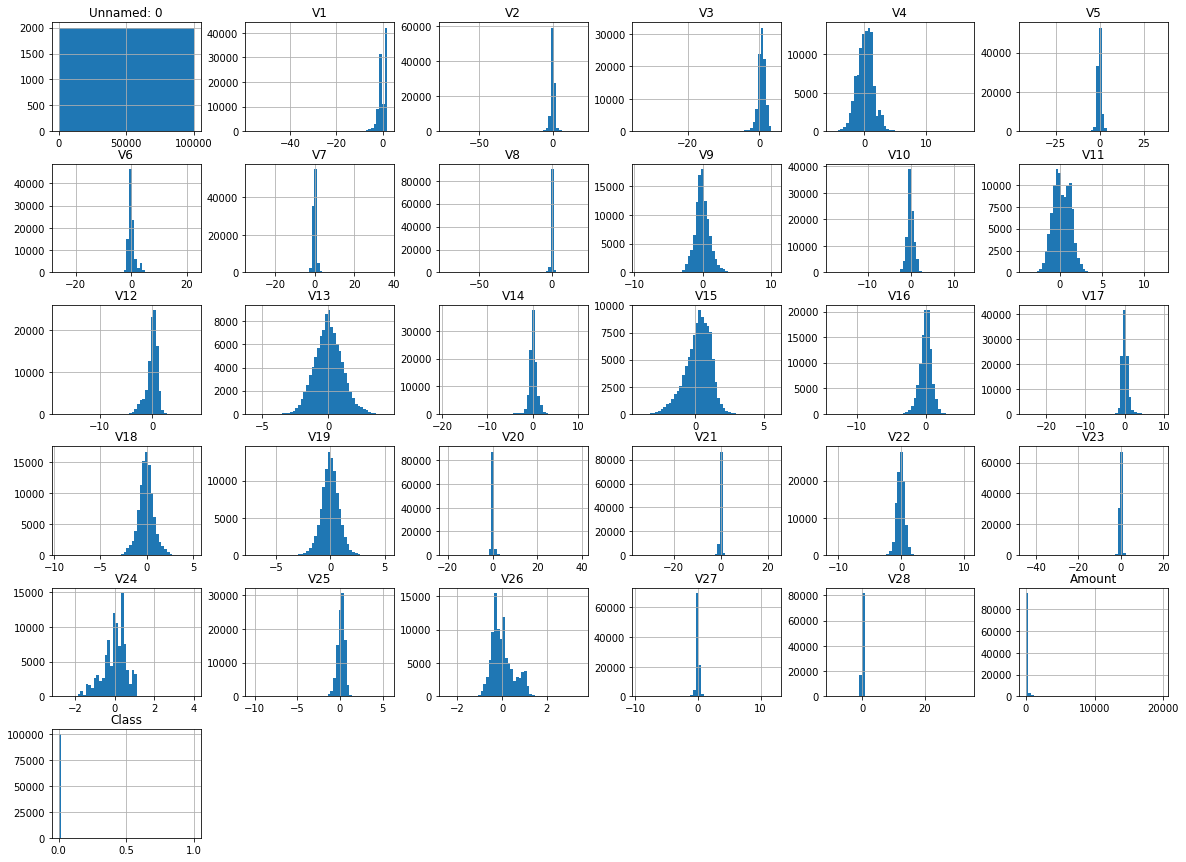

In [47]:
df2.hist(bins=50,figsize=(20,15))
plt.show()

<AxesSubplot:>

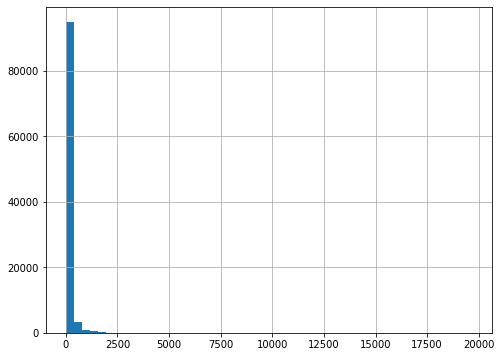

In [48]:
### EDA

df['Amount'].hist(bins=50,figsize=(8,6))

<AxesSubplot:>

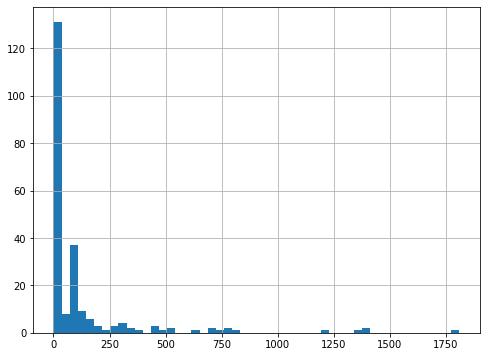

In [49]:
df[df['Class']==1]['Amount'].hist(bins=50,figsize=(8,6))

In [50]:
corr_matrix = df2.corr()

In [51]:
corr_matrix['Class'].sort_values(ascending=False)

Class         1.000000
V11           0.185601
V4            0.166203
V2            0.118394
V8            0.104108
V27           0.062664
V21           0.049098
V19           0.047277
V20           0.019040
V25           0.007828
V26           0.007666
V28           0.005399
Amount        0.003253
V15           0.002281
V13          -0.000782
V22          -0.001041
V24          -0.009129
Unnamed: 0   -0.015521
V23          -0.016656
V6           -0.068307
V9           -0.119891
V5           -0.142983
V1           -0.146549
V18          -0.160144
V7           -0.240844
V16          -0.252847
V10          -0.270631
V12          -0.296582
V3           -0.306701
V14          -0.373653
V17          -0.413776
Name: Class, dtype: float64

<AxesSubplot:>

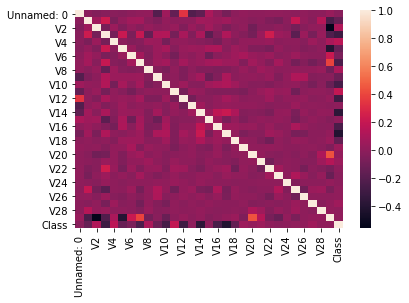

In [52]:
sns.heatmap(corr_matrix)

In [53]:
!pip install Advanced-scorecard-builder

In [54]:
from AmaFree import AdvancedScorecardBuilder as asb

In [55]:
X = df2
t = asb(X,'Class')

In [56]:
t.fit()

Unnamed: 0
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
Amount


In [57]:
t.get_scorecard()

,label,variable,score
0,1.158 < V4 <= 1.632,V4,42
1,2.474 < V4,V4,86
2,1.632 < V4 <= 2.474,V4,102
3,(not missing) and V4 <= 1.158,V4,133
4,-2.246 < V12 <= -1.074,V12,42
5,-1.074 < V12 <= -0.276,V12,119
6,-0.276 < V12,V12,152
7,(not missing) and V12 <= -2.246,V12,157
8,-1.199 < V14 <= -0.806,V14,42
9,-0.33 < V14,V14,96


In [58]:
t.model_info_

{'coef': {'V4': 0.6053766486317326,
  'V8': -1.020747834832705,
  'V12': 0.693130179582045,
  'V14': 0.64603233859261,
  'V16': 0.5363985135881946,
  'V21': 0.5843564852911061,
  'V26': 0.7312596005413625,
  'Amount': 0.6601018535366594},
 'p_value': {'V4': 0.0,
  'V8': 0.0,
  'V12': 0.0,
  'V14': 0.0,
  'V16': 0.0,
  'V21': 0.0,
  'V26': 0.0,
  'Amount': 0.0},
 'features': ['V4', 'V8', 'V12', 'V14', 'V16', 'V21', 'V26', 'Amount'],
 'model': 'LogisticRegressionCV',
 'gini': 0.9843043236290496,
 'acc': 0.9990333655544815,
 'Precision': 0.819672131147541,
 'Recall': 0.7352941176470589,
 'F1': 0.7751937984496124,
 'intercept': array([15.65397769])}

In [59]:
t.html_report('raport.html')